# Project: Identify Customer Segments

In this project, we apply unsupervised learning techniques to identify segments from the population that form the core customer base for Bertelsmann Arvato Analytics (a mail-order sales company in Germany). These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected ROI.

There are four files associated with this project however due to having to sign an NDA I can't publish the actual data files to Github.  Below is what each of these files contained.

- 'azdias.csv': Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- 'customers.csv': Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- 'data_Dictionary.md': Detailed information file about the features in the provided datasets.
- 'feature_summary.csv': Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I used this information to cluster the general population into groups with similar demographic properties. Then I will look at how the people in the customers dataset fit into those clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [1]:
#Import standard libraries

import dill
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.style
plt.style.use('fivethirtyeight')

In [2]:
#Load in the general demographics data.
df_azdias = pd.read_csv('azdias.csv', sep=';')

#Load in the feature summary file.
df_feat_sum = pd.read_csv('feature_summary.csv', sep=';')

## Exploratory Data Analysis

In [3]:
#Explore the data and see what kind of shape it is in

missing = df_azdias.isnull().sum().sum()
print("The main dataset has %s rows, %s columns and %s missing values " %(df_azdias.shape[0], df_azdias.shape[1], missing))

print("The summary dataset has %s rows and %s columns"  %(df_feat_sum.shape[0], df_feat_sum.shape[1]))

The main dataset has 891221 rows, 85 columns and 4896838 missing values 
The summary dataset has 85 rows and 4 columns


In [4]:
df_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
df_feat_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [6]:
#Descriptive stats
df_azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
df_feat_sum.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,CAMEO_DEU_2015,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
df_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
df_feat_sum.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Preprocessing

The feature summary file contains a summary of for each demographics data column. I used this file to make preprocessing decisions.

The fourth column of the feature attributes summary documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this with numbers, we will replace it and fill it in appropriate NaN values.

We do this with the function below.

In [10]:
def clean_null(df):
    for x in range(len(df_feat_sum)):
        missing_or_unknown = df_feat_sum.iloc[x]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') 
                              else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df_azdias = df.replace({df_feat_sum.iloc[x]['attribute']: missing_or_unknown}, np.nan)
     
    return df_azdias

df_azdias = clean_null(df_azdias)

missing_now = df_azdias.isnull().sum().sum()
missing_increase = (missing / missing_now) * 100
missing_increase_str = str(missing_increase)
print('The total number of missing values has changed from %s to %s which represents an increase of %s percent post function' 
      %(missing, missing_now, missing_increase_str[:5]))

The total number of missing values has changed from 4896838 to 4896997 which represents an increase of 99.99 percent post function


### Visually Assess Missing Data in Columns

In [11]:
#Counts of how much data is missing in each row of df_azdias
missing_column_data = df_azdias.isnull().sum(axis=0)

#Create a proportion
prop_missing_column_data = missing_column_data/len(df_azdias)

The following functions allows us to visually assess missing data in each column.

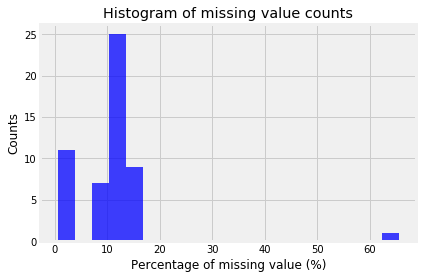

In [12]:
#Perform an assessment of the percentage of how how much missing data there is in each column of the dataset.

def missing_column_data_percent_plot(df):
    #Prep to plot
    missing = df.isnull().sum()
    missing = missing[missing > 0]/(df.shape[0]) * 100
    missing.sort_values(inplace=True)
    
    #Plot distribution of missing value counts
    plt.hist(missing, bins=20, facecolor='b', alpha=0.75)
    plt.xlabel('Percentage of missing value (%)')
    plt.ylabel('Counts')
    plt.title('Histogram of missing value counts')
    plt.grid(True)
    plt.show()
    
missing_column_data_percent_plot(df_azdias)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


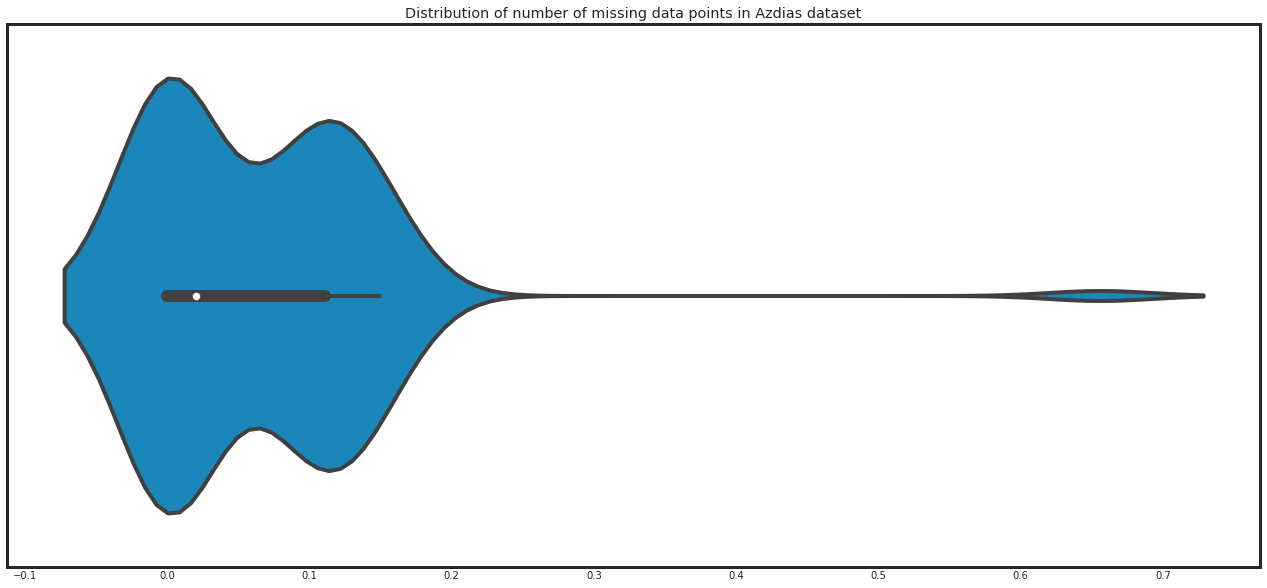

In [13]:
#Violin Plot

def violin_plot(df, plot_data):
    sns.set_style("ticks")
    fig = plt.figure(figsize=(20,10))
    ax = sns.violinplot(plot_data)
    ax.set_title("Distribution of number of missing data points in Azdias dataset")
    plt.show()

violin_plot(df_azdias, prop_missing_column_data)

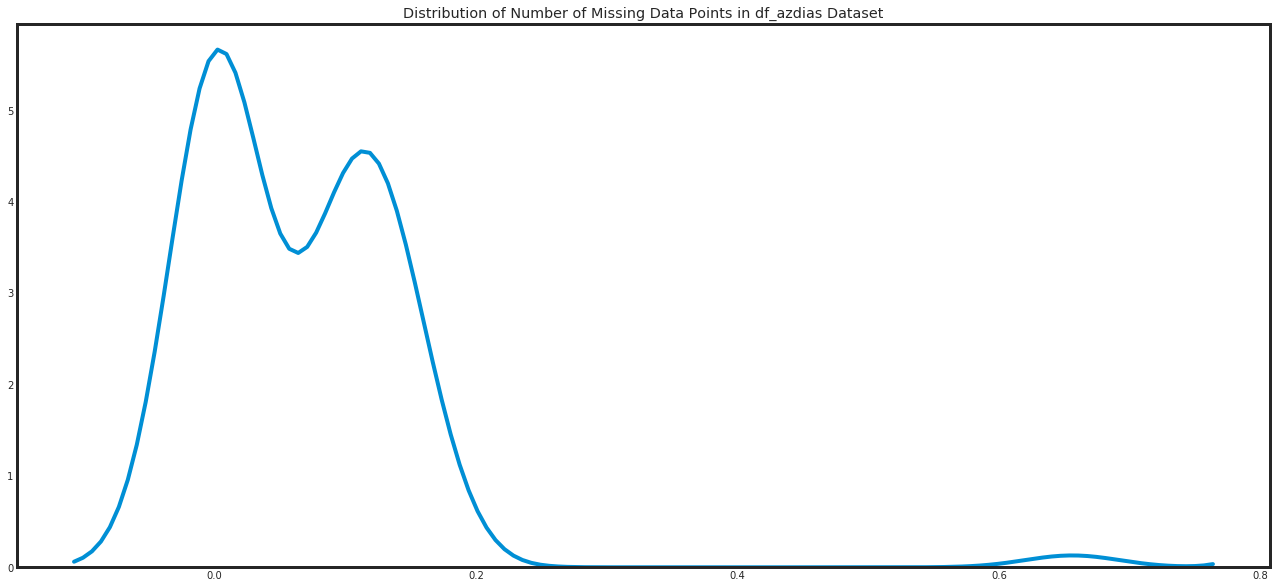

In [14]:
#KDE plot

def kde_plot(df, data):
    sns.set_style("ticks")
    fig = plt.figure(figsize=(20,10))
    ax = sns.kdeplot(data)
    ax.set_title("Distribution of Number of Missing Data Points in df_azdias Dataset")
    plt.show()
    
kde_plot(df_azdias, prop_missing_column_data)

We can see based on the 3 different graphs above that columns with more than 20% missing values are outliers. Next, let's investigate those columns and decide if we can drop them from the dataframe. 

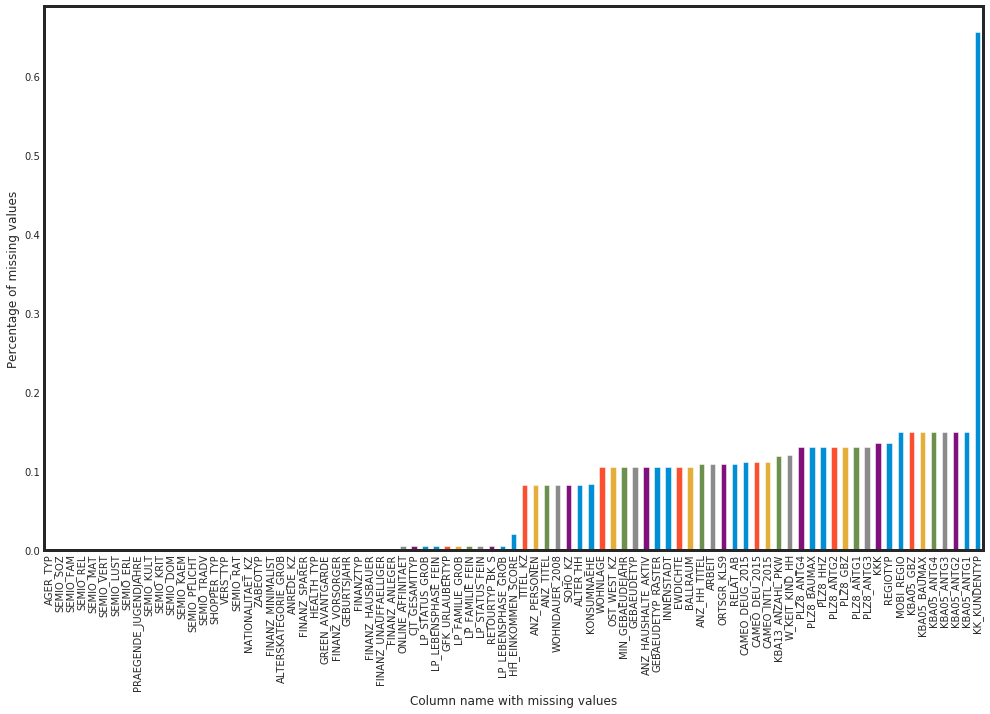

There are 85 columns with missing values.


In [15]:
def missing_data_by_column(df):
    prop_missing_column_data.sort_values(inplace=True)
    prop_missing_column_data.plot.bar(figsize=(15,10))
    plt.xlabel('Column name with missing values')
    plt.ylabel('Percentage of missing values')

    plt.show()
    print("There are %s columns with missing values." %(len(prop_missing_column_data)))

missing_data_by_column(df_azdias)

Based on all the charts from above we see that the most columns have fewer than 30% of missing data points. We will thus eliminate any column which has more than 30% of missing data points.  Originally this was at 20% but using that metric for the second data set wiped out a good amount of data.

In [16]:
#The following columns are those we will drop: 

def drop_columns_greater_than_30(df_azdias):
    print (set(df_azdias.columns[df_azdias.isnull().mean() > 0.30]))
    df_azdias = df_azdias.dropna(thresh=0.8*len(df_azdias), axis=1)

drop_columns_greater_than_30(df_azdias)

{'KK_KUNDENTYP'}


The columns with lots of missing data tended to be those of individual records, like people's titles, dates of birth, etc.

I removed six columns from the data: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'.

### Visually Assess Missing Data in Rows

This is very similar to what we did above for columns

In [17]:
#Counts of how much data is missing in each row of df_azdias
missing_row_data = df_azdias.isnull().sum(axis=1)

#Create a propotion
prop_missing_row_data = missing_row_data/df_azdias.shape[1]

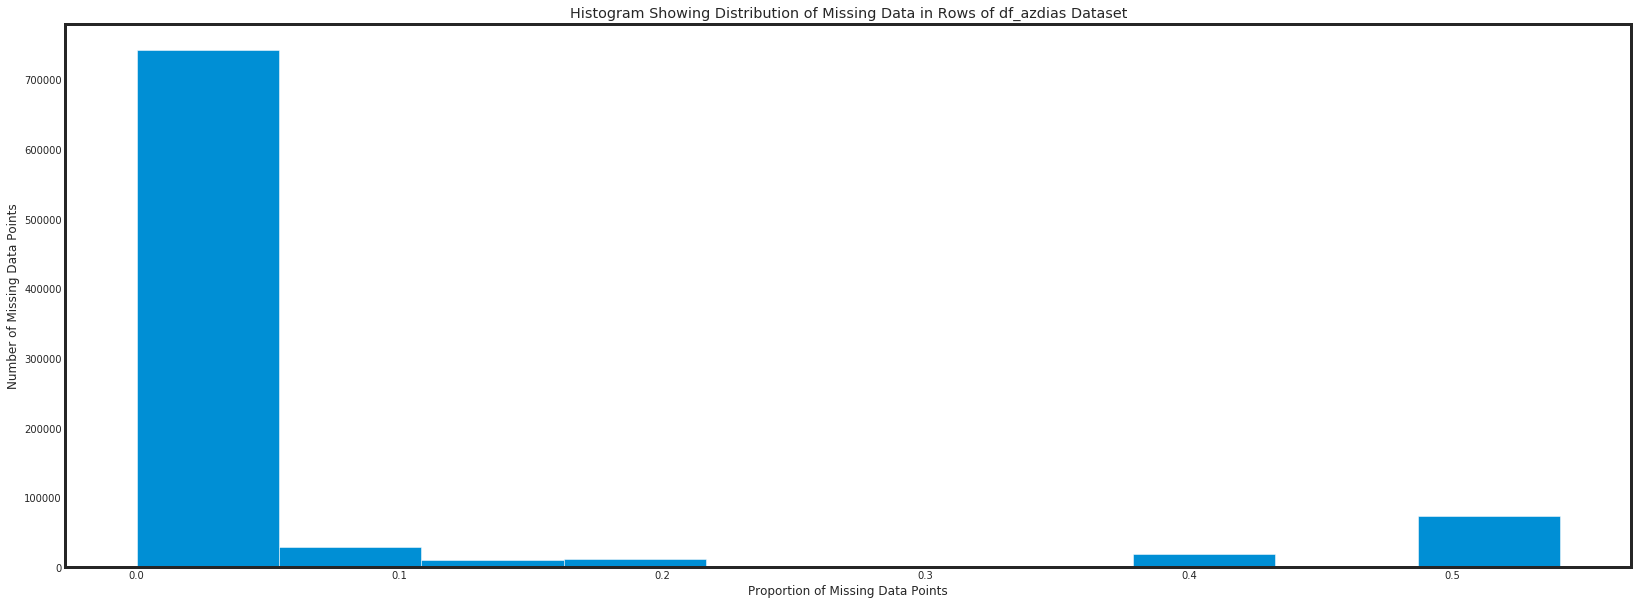

In [18]:
#Histogram to visualize & count proportions of missing data 

def missing_row_data_percent_plot(df):
    fig = plt.figure(figsize=(25,10))
    sns.set_style("ticks")
    ax = prop_missing_row_data.plot.hist()
    ax.set_title("Histogram Showing Distribution of Missing Data in Rows of df_azdias Dataset")
    ax.set_xlabel("Proportion of Missing Data Points")
    ax.set_ylabel("Number of Missing Data Points")
    plt.show()
    
missing_row_data_percent_plot(df_azdias)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


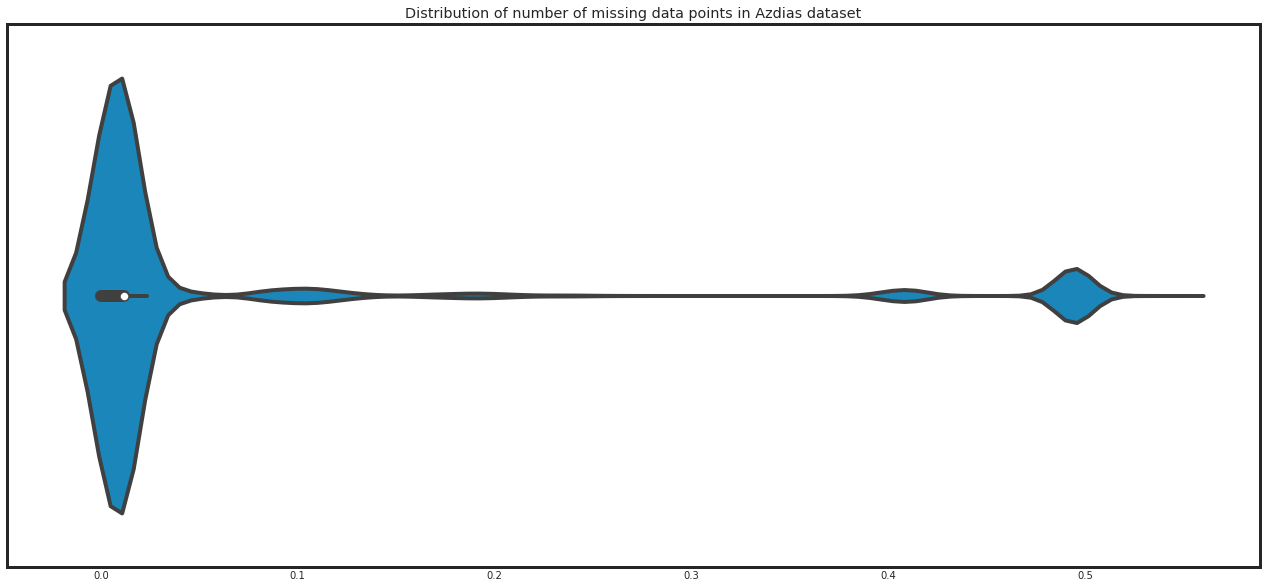

In [19]:
#Reuse our function from above
violin_plot(df_azdias, prop_missing_row_data)

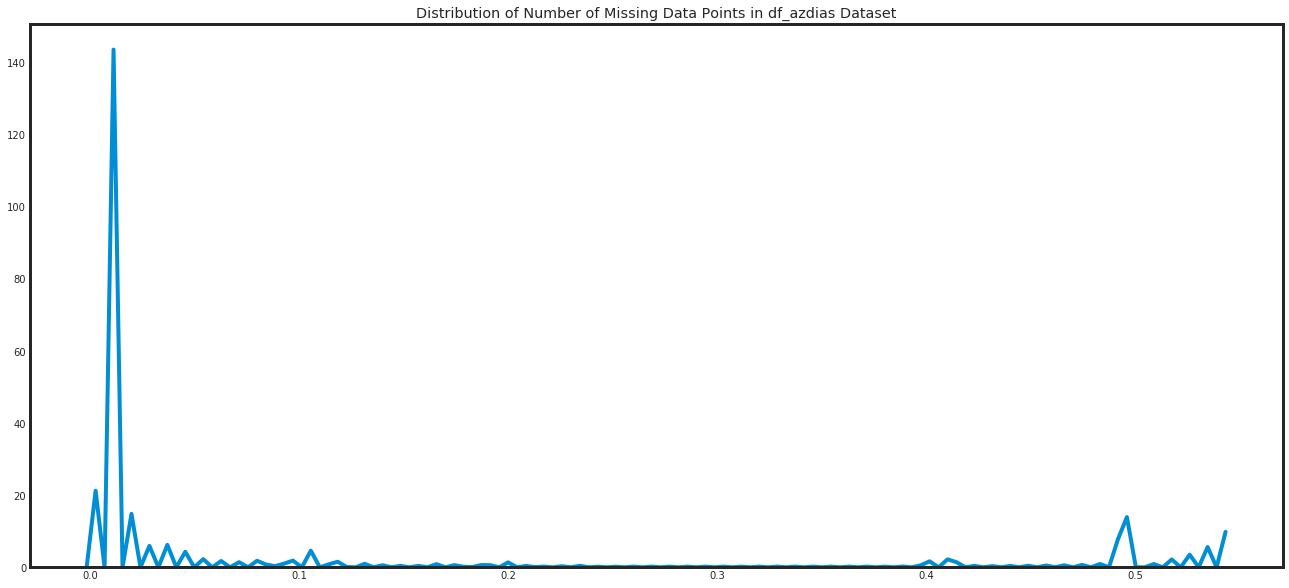

In [20]:
#Reuse our function from above
kde_plot(df_azdias, prop_missing_row_data)

Now we divide the dataset into two subsets based on the number of missing values in each row. The first dataset is comprised of rows with 3 or less missing values and the second dataset contains everything else.

In [21]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

df_azdias_less_than_3 = df_azdias[df_azdias.isnull().sum(axis=1) <= 3].reset_index(drop=True)
df_azdias_more_than_3 = df_azdias[df_azdias.isnull().sum(axis=1) > 3].reset_index(drop=True)

In [22]:
#See which random 5 columns we will choose for comparision
df_azdias_less_than_3.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [23]:
#Compare the distribution of values for at least five columns where there are no or few missing values, between the two
#subsets.

#Upgrading to matplot lib 3.3 destroys the formatting.

def compare_distributions(feature):
    fig = plt.figure(figsize=(10,5))
    fig.suptitle("Comparison of datasets with missing values and datasets without missing values")
    plt.subplot(1,2,1)
    ax1 = sns.countplot(data = df_azdias_less_than_3, x=df_azdias_less_than_3[feature])
    ax1.set_xlabel("Values")
    ax1.set_ylabel("Counts")
    ax1.set_title("Dataset with 3 or fewer missing Values")
    plt.subplot(1,2,2)
    ax2 = sns.countplot(data=df_azdias_more_than_3, x=df_azdias_more_than_3[feature])
    ax2.set_title("Dataset with more than 3 missing values")
    ax2.set_xlabel("Values")
    ax2.set_ylabel("Counts")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88, wspace=0.6)
    plt.show()

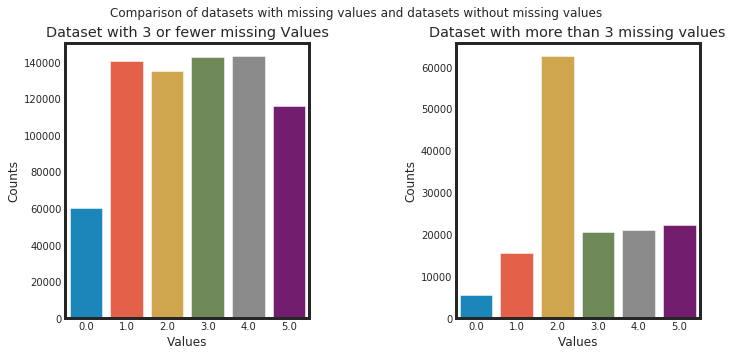

In [24]:
compare_distributions('ONLINE_AFFINITAET')

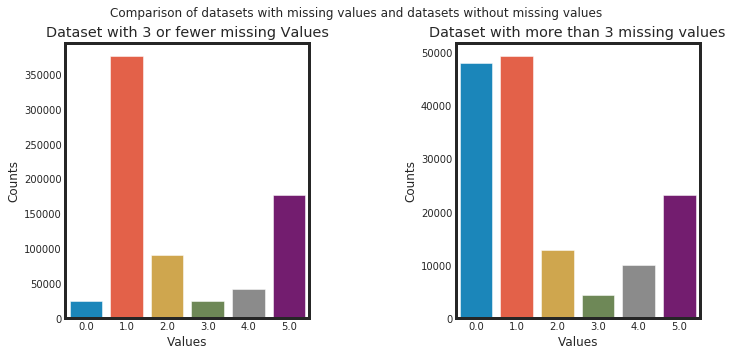

In [25]:
compare_distributions('LP_FAMILIE_GROB')

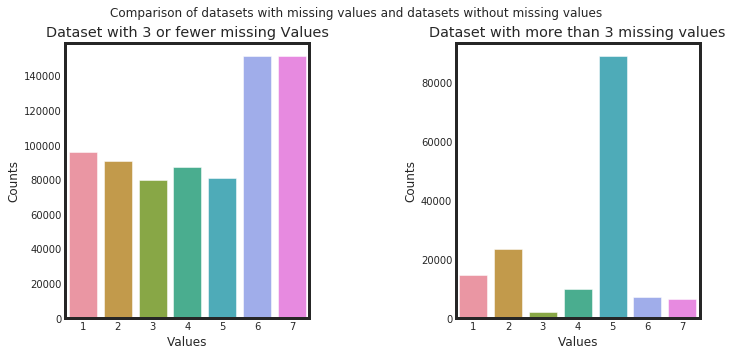

In [26]:
compare_distributions('SEMIO_LUST')

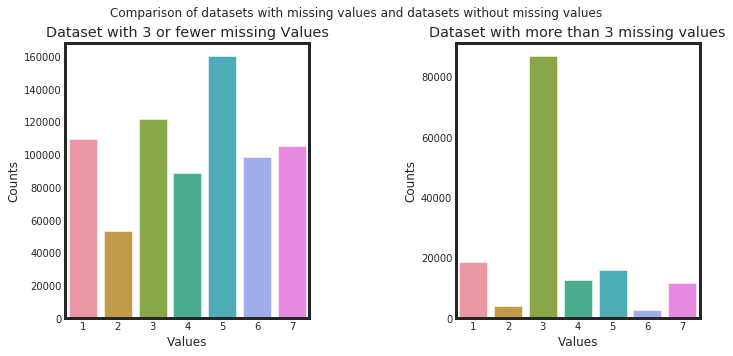

In [27]:
compare_distributions('SEMIO_KULT')

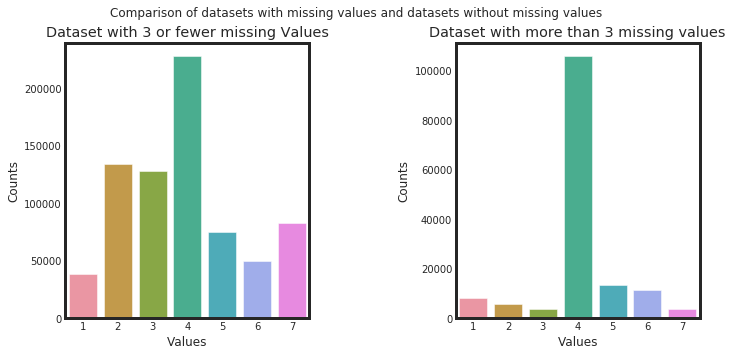

In [28]:
compare_distributions('SEMIO_RAT')

From the bar charts above, we can see the distributions of values between both datasets are different for some features. Thus, we will concentrate on the dataset with no missing values.

### Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [29]:
#Make the naming easier
df2_azdias = df_azdias_less_than_3

In [30]:
#How many features are there of each data type?
df_feat_sum['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [31]:
#Future garbage collector placeholder
categorical_columns_to_drop=[]

#Assess categorical variables: 

categorical_features = df_feat_sum[df_feat_sum["type"]=="categorical"]["attribute"]
df_categorical_features = pd.DataFrame()

def classify_features(df):
    features = []
    number_of_categories = []
    for feature in categorical_features: 
        if feature in list(df):
            features.append(feature)
            number_of_categories.append(len(df[feature].unique()))
        else:
            pass
    df_categorical_features['features'] = features
    df_categorical_features['number_of_categories'] = number_of_categories

      
classify_features(df2_azdias)

##### Binary Categorical Variables:

In [32]:
#We use 3 because the nan's that haven't been removed still count as a value as evidenced below in OST_WEST_KZ
df_categorical_features.query('number_of_categories <= 3')

,features,number_of_categories
1,ANREDE_KZ,2
5,GREEN_AVANTGARDE,2
12,SOHO_KZ,2
14,VERS_TYP,3
18,OST_WEST_KZ,2


In [33]:
#Values...  This is binary but needs to be re-encoded since it uses non-numeric values ('W' for West and 'O' for East).
df2_azdias['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [34]:
#Function to re-encode into a binary categorical

def fix_ost_west_kz(df):
    numeric_ost_west_values = {'W': 1, 'O': 0}
    df.replace(numeric_ost_west_values, inplace=True)
    
fix_ost_west_kz(df2_azdias)

In [35]:
df2_azdias['OST_WEST_KZ'].value_counts()

1    581406
0    156955
Name: OST_WEST_KZ, dtype: int64

##### Multi-level variables

In [36]:
df_categorical_features.query('number_of_categories > 3')

,features,number_of_categories
0,AGER_TYP,5
2,CJT_GESAMTTYP,6
3,FINANZTYP,6
4,GFK_URLAUBERTYP,12
6,LP_FAMILIE_FEIN,12
7,LP_FAMILIE_GROB,6
8,LP_STATUS_FEIN,10
9,LP_STATUS_GROB,5
10,NATIONALITAET_KZ,4
11,SHOPPER_TYP,5


### Discussion
From looking at the description in the data dictionary of the remaining categorical features in the dataset, I came to the
following conclusions:

'CACAMEO_DEUG_2015' and 'CAMEO_DEU_2015' at different scales both describe the wealth and life stage.  I will keep
'CAMEO_DEUG_2015', that which describes the typology at the rough scale.

The same is true of 'LP_FAMILIE_FEIN' / 'LP_FAMILIE_GROB' and 'LP_STATUS_FEIN' / 'LP_STATUS_GROB'.
I also drop 'GEBAEUDETYP', which is a building-level feature, which simply describes the types of buildings and probably
has no value going forward.

After I drop the un-needed columns we will one-hot-encode the rest of the categorical variables

In [37]:
categorical_columns_to_drop.append(['CAMEO_DEU_2015','LP_STATUS_FEIN','LP_FAMILIE_FEIN', 'GEBAEUDETYP'])

df2_azdias = pd.get_dummies(df2_azdias, columns=['NATIONALITAET_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 
                                    'LP_FAMILIE_GROB','LP_STATUS_GROB', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015'])

#### Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [38]:
# "PRAEGENDE_JUGENDJAHRE" engineer two new variables:

def praegende_jugendjahre(df):
    df['praegende_jugendjahre_decade'] = df['PRAEGENDE_JUGENDJAHRE']
    df['praegende_jugendjahre_movement'] = df['PRAEGENDE_JUGENDJAHRE']
    decade_replacement_dictionary = {2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df['praegende_jugendjahre_decade'].replace(decade_replacement_dictionary, inplace=True)
    movement_replacement_dictionary = {3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}
    df['praegende_jugendjahre_movement'].replace(movement_replacement_dictionary, inplace=True)
    categorical_columns_to_drop.append('PRAEGENDE_JUGENDJAHRE')

praegende_jugendjahre(df2_azdias)

In [39]:
# "CAMEO_INTL_2015"  engineer two new variables:

def cameo_intl_2015(df):
    wealth_dictionary = {}
    lifestage_dictionary = {}
    for i in range (1,6):
        for j in range(1,6):
            key = str(i * 10 + j)
            wealth_dictionary[key] = i
            lifestage_dictionary[key] = j
    df['cameo_intl_2015_wealth'] = df['CAMEO_INTL_2015'].replace(wealth_dictionary)
    df['cameo_intl_2015_life_stage'] = df['CAMEO_INTL_2015'].replace(lifestage_dictionary)
    categorical_columns_to_drop.append('CAMEO_INTL_2015')
    df = df[df.cameo_intl_2015_wealth != 'XX']
    return df

df2_azdias = cameo_intl_2015(df2_azdias)

In [40]:
df2_azdias = df2_azdias[df2_azdias['cameo_intl_2015_wealth'] != 'XX']

#### Complete Feature Selection

In order to finish this step up, we need to make sure that our dataframe now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [41]:
df2_azdias['PLZ8_BAUMAX'].unique()

array([1., 2., 4., 5., 3.])

In [42]:
df2_azdias['PLZ8_BAUMAX'].value_counts()

1.0    469604
5.0     95220
2.0     68403
4.0     55317
3.0     49535
Name: PLZ8_BAUMAX, dtype: int64

In [43]:
#Separate out building types in PLZ8_BAUMAX feature to residential & business

def plz8_baumax_seperate(df):
    building_types = {2:1, 3:1, 4:1, 5:2}
    df['plz8_baumax_buildings'] = df['PLZ8_BAUMAX'].replace(building_types)

plz8_baumax_seperate(df2_azdias)

In [44]:
df2_azdias['plz8_baumax_buildings'].value_counts()

1.0    642859
2.0     95220
Name: plz8_baumax_buildings, dtype: int64

In [45]:
#Add the rest of the features we don't need

categorical_columns_to_drop.append(['PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 
                                    'CAMEO_DEU_2015','CAMEO_INTL_2015'])

#Take one last look before we toss
categorical_columns_to_drop

[['CAMEO_DEU_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GEBAEUDETYP'],
 'PRAEGENDE_JUGENDJAHRE',
 'CAMEO_INTL_2015',
 ['PRAEGENDE_JUGENDJAHRE',
  'WOHNLAGE',
  'LP_LEBENSPHASE_FEIN',
  'LP_LEBENSPHASE_GROB',
  'CAMEO_DEU_2015',
  'CAMEO_INTL_2015']]

In [46]:
#We have an irregular list of lists so we need to "flatten" the list before we drop everything.

final_categorical_drop_list=[]
def flatten_categorical_list(categorical_columns_to_drop):
    for x in categorical_columns_to_drop:
        if isinstance(x, list):
            for y in x:
                final_categorical_drop_list.append(y)
        else:
            final_categorical_drop_list.append(x)

flatten_categorical_list(categorical_columns_to_drop)
final_categorical_drop_list

['CAMEO_DEU_2015',
 'LP_STATUS_FEIN',
 'LP_FAMILIE_FEIN',
 'GEBAEUDETYP',
 'PRAEGENDE_JUGENDJAHRE',
 'CAMEO_INTL_2015',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015']

In [47]:
#Drop everything not needed
df2_azdias.drop(final_categorical_drop_list, axis=1, inplace=True)

### Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, we'll need to perform the same cleaning steps on the customer demographics data. 

In [83]:
def clean_data(df_customers):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    clean_null(df_customers)
    drop_columns_greater_than_30(df_customers)
    df_customers[df_customers.isnull().sum(axis=1) <= 3].reset_index(drop=True)
    fix_ost_west_kz(df_customers)
    df_customers = pd.get_dummies(df_customers, columns=['NATIONALITAET_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 
    'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB','LP_STATUS_GROB', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015'])
    categorical_columns_to_drop2 = ['CAMEO_DEU_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GEBAEUDETYP',
                                    'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'LP_LEBENSPHASE_FEIN', 
                                    'LP_LEBENSPHASE_GROB']
    praegende_jugendjahre(df_customers)
    plz8_baumax_seperate(df_customers)
    df_customers.drop(categorical_columns_to_drop2, axis=1, inplace=True)
    df_customers.head
    return df_customers
#     #categorical_columns_to_drop.append(['CAMEO_DEU_2015','LP_STATUS_FEIN','LP_FAMILIE_FEIN', 'GEBAEUDETYP'])

#     
#     cameo_intl_2015(df_customers)
#     
#     #categorical_columns_to_drop.append(['PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'LP_LEBENSPHASE_FEIN', 
#     #'LP_LEBENSPHASE_GROB', 'CAMEO_DEU_2015','CAMEO_INTL_2015'])
#     df_customers.drop(categorical_columns_to_drop, axis=1, inplace=True)
#     df_customers.head

## Feature Transformation

### Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [49]:
def scale_impute(df):
    df2_azdias_imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=1)
    df2_azdias_imputed = df2_azdias_imputer.fit_transform(df)
    standard_scaler = StandardScaler()
    df2_azdias_scaled = standard_scaler.fit_transform(df2_azdias_imputed)
    return pd.DataFrame(df2_azdias_scaled, columns=list(df))

df3_azdias = scale_impute(df2_azdias)

In [50]:
df3_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738079 entries, 0 to 738078
Columns: 132 entries, AGER_TYP to plz8_baumax_buildings
dtypes: float64(132)
memory usage: 743.3 MB


### Perform Dimensionality Reduction

We are now ready to apply dimensionality reduction techniques.

In [51]:
# Apply PCA to the data

def apply_pca(df3_azdias):
    pca = PCA()
    return pca.fit(df3_azdias)

pca = apply_pca(df3_azdias)

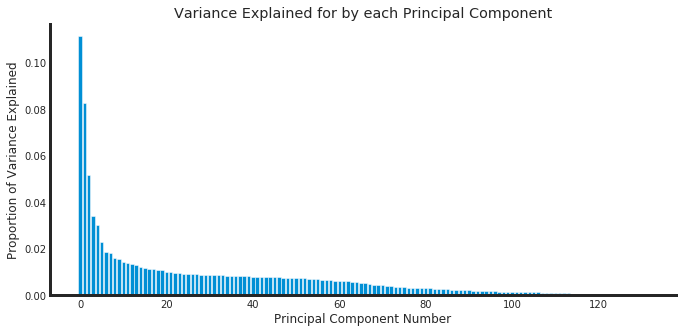

In [52]:
#Investigate the variance accounted for by each principal component

fig = plt.figure(figsize=(10,5))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("Principal Component Number")
plt.ylabel("Proportion of Variance Explained")
plt.title("Variance Explained for by each Principal Component")
sns.despine()
plt.show()

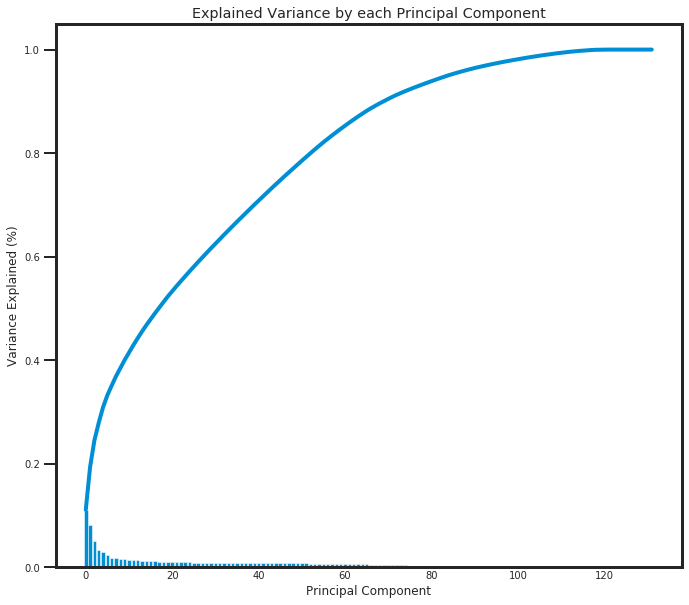

In [53]:
#Build a scree plot.  Just another way to look at the same data

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    number_of_components = len(pca.explained_variance_ratio_)
    ind = np.arange(number_of_components)
    pca_explained_variance_ratio = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(pca_explained_variance_ratio)
    ax.bar(ind, pca_explained_variance_ratio)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance by each Principal Component')

scree_plot(pca)

In [54]:
#Tell us how many features to keep based on the percentage of variance explained

def keep_pca_features_based_on_variance_explained(percentage):
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    number_of_components = int(np.argwhere(explained_variance_ratio>=percentage)[1])
    print("We keep %s components for modeling because they explain %s of the variance in the data."
          %(number_of_components, int(percentage*100)))

keep_pca_features_based_on_variance_explained(.80)

We keep 54 components for modeling because they explain 80 of the variance in the data.


In [55]:
#Apply actual PCA with 50 components

def apply_pca(df):
    pca = PCA(n_components=53)
    df4_azdias = pca.fit_transform(df)
    df4_azdias = pd.DataFrame(df4_azdias)
    return df4_azdias

df4_azdias_pca = apply_pca(df3_azdias)

In [56]:
#Let's take a look at the new dataframe post conversion
df4_azdias_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,4.325085,-3.058734,-2.692815,-0.687043,-1.022305,-0.833476,0.235312,4.514405,-1.443635,0.454710,...,-0.476098,-1.283405,5.287857,-0.412850,2.703780,-3.285374,2.833612,0.921210,3.000174,0.375645
1,-0.715506,-1.099015,-3.475189,-1.972552,-0.297607,-3.021423,-0.653295,0.317528,-1.382447,1.309603,...,0.018853,-0.363790,-0.186396,0.311618,-0.051448,-0.083452,-0.359575,1.526056,1.233643,0.042819
2,-4.987387,1.701237,-0.962144,0.583777,-0.664020,-0.414281,2.812407,-0.282226,1.344471,0.539213,...,1.336493,-1.915733,-0.324486,-1.783580,0.131241,0.070936,-0.479107,-0.382002,-0.224820,0.681463
3,-0.124990,-0.116116,3.082714,-1.108915,0.134480,2.276563,-4.487599,-0.659700,0.093668,1.709991,...,-0.327030,0.204794,-0.650687,0.335370,0.214114,0.036944,1.895846,0.505008,0.498652,-1.876582
4,-1.347518,-0.679470,-0.708820,2.327186,-1.792621,-2.795405,-2.008908,0.782634,0.379689,0.194018,...,0.958511,-0.160595,-0.067379,-1.384930,1.136253,0.389489,0.123682,0.267403,-1.669691,1.686771


### Interpret Principal Components

Now that we have our transformed principal components, let's check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

The interpretations came from the provided data dictionary which because of a NDA I was unable to share.

In [57]:
#Map weights for the first principal component to corresponding feature names and then print the linked values, sorted by
#weight.

def pca_weights(pca, n):
    df = pd.DataFrame(pca.components_, columns=list(df3_azdias.columns))
    components = df.iloc[n].sort_values()
    return components

print(pca_weights(pca, 0))

MOBI_REGIO                       -0.211585
KBA05_ANTG1                      -0.196754
FINANZ_MINIMALIST                -0.194932
PLZ8_ANTG1                       -0.193573
KBA05_GBZ                        -0.189126
PLZ8_GBZ                         -0.144453
KONSUMNAEHE                      -0.142657
INNENSTADT                       -0.136185
LP_STATUS_GROB_5.0               -0.113794
cameo_intl_2015_life_stage       -0.112997
LP_STATUS_GROB_4.0               -0.110998
praegende_jugendjahre_movement   -0.105887
BALLRAUM                         -0.103671
GREEN_AVANTGARDE                 -0.103651
GEBAEUDETYP_RASTER               -0.102305
ZABEOTYP_1                       -0.097034
FINANZ_VORSORGER                 -0.095257
CAMEO_DEUG_2015_2                -0.089022
ALTERSKATEGORIE_GROB             -0.086355
FINANZTYP_2                      -0.084758
ANZ_PERSONEN                     -0.076361
NATIONALITAET_KZ_1               -0.074208
CAMEO_DEUG_2015_4                -0.073438
KBA13_ANZAH

In [58]:
# Map weights for the second principal component to corresponding feature names and then print the linked values, sorted
# by weight.

print(pca_weights(pca, 1))

FINANZ_SPARER                  -0.222420
praegende_jugendjahre_decade   -0.220136
SEMIO_REL                      -0.216154
FINANZ_UNAUFFAELLIGER          -0.212153
SEMIO_TRADV                    -0.209270
SEMIO_PFLICHT                  -0.206042
FINANZ_ANLEGER                 -0.197070
SEMIO_KULT                     -0.174802
ONLINE_AFFINITAET              -0.162754
SEMIO_RAT                      -0.162091
SEMIO_FAM                      -0.140078
SEMIO_MAT                      -0.132711
FINANZTYP_1                    -0.124276
ZABEOTYP_4                     -0.103023
ALTER_HH                       -0.096448
ZABEOTYP_5                     -0.095284
FINANZTYP_4                    -0.094426
FINANZTYP_3                    -0.076246
PLZ8_ANTG1                     -0.075062
MOBI_REGIO                     -0.074559
KBA05_GBZ                      -0.074074
SEMIO_SOZ                      -0.070285
GFK_URLAUBERTYP_9.0            -0.070225
KBA05_ANTG1                    -0.065859
ZABEOTYP_1      

In [59]:
# Map weights for the third principal component to corresponding feature namesand then print the linked values, sorted by
# weight.

print(pca_weights(pca, 2))

ANREDE_KZ                        -0.347579
SEMIO_KAEM                       -0.318321
SEMIO_DOM                        -0.284007
SEMIO_KRIT                       -0.261492
SEMIO_ERL                        -0.200381
SEMIO_RAT                        -0.168607
FINANZ_ANLEGER                   -0.159866
FINANZTYP_1                      -0.113276
SHOPPER_TYP_2                    -0.087736
SHOPPER_TYP_-1                   -0.080851
NATIONALITAET_KZ_0               -0.080772
FINANZ_SPARER                    -0.070921
FINANZ_UNAUFFAELLIGER            -0.064740
ZABEOTYP_4                       -0.063862
FINANZ_HAUSBAUER                 -0.059905
INNENSTADT                       -0.052325
PLZ8_ANTG1                       -0.050761
LP_FAMILIE_GROB_3.0              -0.047041
SEMIO_PFLICHT                    -0.044333
KONSUMNAEHE                      -0.044016
BALLRAUM                         -0.043757
PLZ8_GBZ                         -0.042465
SHOPPER_TYP_3                    -0.039452
GEBAEUDETYP

#### First Principal Component:
This component is negatively correlated with the features associated with movement patterns (with high values indicating low to no movement), low financial interest typology (with high values indicating a low dimension) and number of 1-2 family houses in the KBA05 microcell (with high values here indicating a very high number in the microcell).

It is positively correlated with the features associated with low-income earners, number of 6-10 family houses in the PLZ8 region & number of 10+ family houses in the same region (with high values indicating more houses).


#### Second Principal Component:
This component is negatively correlated with the features indicating decade of a person's youth & thus generation (with high values indicating those whose youth was in the 80s and 90s - millenials), religious affinity (with high values here indicating a low religious affinity), and financial inconspicuous (with high values indicating a low affinity).

It is positively correlated with the features representing age (with high values indicating higher age ranges & thus older people), a financial typology of "be-prepared" (with high values indicating a low interest), and energy consumption typology.


#### Third Principal Component
This component is negatively correlated with Gender (there is no support for anything other than Male / Female), a combative attitude and being dominant-minded (with higher values indicating a lower affinity for both traits).

It is positively correlated with the features representing dreamfulness, social-mindedness and family-mindedness. For all three of these features, high values indicate lower affinities.

## Clustering

### Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. We will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Compute the average difference from each point to its assigned cluster's center. 
- Perform the above two steps for a number of different cluster counts. We can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. We use this fact to select a final number of clusters in which to group the data.
- Once we've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that we also obtain the cluster assignments for the general demographics data, since we'll be using them in the final step of the project

Text(0.5, 1.0, 'SSE vs. K')

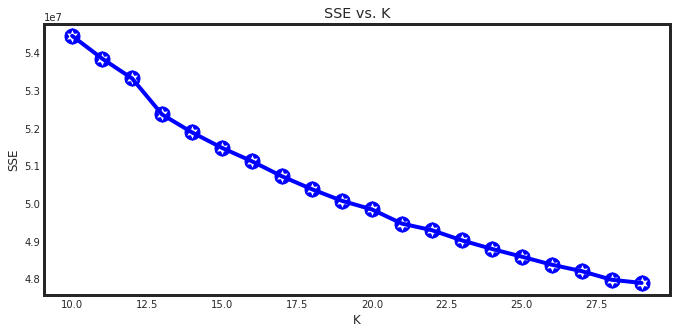

In [60]:
# Run K-means clustering on the data over a number of different cluster counts & compute the average within-cluster 
# distances.

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #Instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    #Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    #Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(10,30))

for center in centers:
    scores.append(get_kmeans_score(df4_azdias_pca, center))
  

fig = plt.figure(figsize=(10,5))
star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)
plt.plot(centers, scores, linestyle='-', marker=cut_star, color='b', markersize=15)
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population
#demographics data.

kmeans = KMeans(n_clusters = 27)
df_azdias_kmeans_clusters = kmeans.fit_predict(df4_azdias_pca)

### Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Let's not confuse this with re-fitting all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. This is last step of the project, and we will interpret how the general population fits apply to the customer data.

- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function we created earlier. (We can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we will not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor will we be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [62]:
dill.dump_session('notebook_env.db')

In [97]:
del df_customers

In [98]:
# Load in the customer demographics data then apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the customer demographics data using our function
# we definied previously

df_customers = pd.read_csv("customers.csv", sep=";")

def clean_customers(df):
    df_clean_customers = clean_data(df_customers)
    df2_clean_customers = scale_impute(df_clean_customers)
    df3_clean_customers = apply_pca(df2_clean_customers)
    customers_clusters = kmeans.predict(df3_clean_customers)
    return customers_clusters

customers_clusters = clean_customers(df_customers)

{'KK_KUNDENTYP'}


### Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final step, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



In [ ]:
# dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')